In [1]:
import h5py
from warnings import warn
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import xarray as xr

import seaborn as sns
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from statsmodels.tsa.stattools import adfuller

# Introduction

This notebook contains some analysis and exlporation of the data used for both the classification and confrontation. The data used here is not the "raw data", i.e. as downloaded from the source, but it has gone through some other cleaning and processing. 

This notebook confronts the simulated data model, from the CAM5 model (downloaded as the [ExtremeWeather dataset](https://extremeweatherdataset.github.io)), with some real recordings, obtained from the [Physical Society Webpage](https://psl.noaa.gov/cgi-bin/db_search/DBListFiles.pl?did=195&tid=92225&vid=31). Both data analysed depict the U850 wind variable, which is the wind velocity at 850 millibars. Classifiers with other variables are possible, as tested throughout this work, but the used variable showed the best overall results.

Obviously, much of the work has been plagued by a lack of data and computational resources, and the results presented are the best ones achievable with limited computation power and storage.

# Loading data

## CAM5 data

In [2]:
# load the CAM5 model data
simulated_data = h5py.File(
    "./data.nosync/georeferenced_wind_extremewearge_2005.h5", 'r')
# this data contains:
# (data) the 3 variables of interest (U850, UBOT, V850) (see https://extremeweatherdataset.github.io)
# (boxes) contains information as to where the cyclon is
# (latitude)
# (longitude)
# (time) saved as int8, contains the hour, day, month and year of the data

Since using all of the variables would be too expensive, and since most of the interest lies on the **U850** variables, only this shall be selected. This allows to keep at a minimum the amount of RAM used.
This data shall be saved in a ```numpy``` array, which is fairly easy to treat. The time, latitude and longitude shall be kept in the h5df file, since there is no need to move them to new variables.

In [3]:
# just consider the U850 variable (from the pre-processed data, in the 1st column)
simulated_U850 = simulated_data['data'][:, 0, :, :]

print("Data shape:", simulated_U850.shape)
# the orded of dimensions is as follow: (time, lat, lon)

Data shape: (1456, 768, 1152)


In [4]:
# load time and change from int to numpy datetime64
simulated_time = simulated_data['time'][()].astype("<M8[us]")

## Real data PhysicalSociety

In [5]:
# load the model generated data
print("Load real data")
datapath = './data.nosync/uwnd.sig995.2005.nc'
dataset = xr.load_dataset(datapath)
# this data is already for the year 2005

Load real data


In [6]:
dataset

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 1460)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2005-01-01 ... 2005-12-31T18:00:00
Data variables:
    uwnd     (time, lat, lon) float32 -3.6 -3.9 -4.2 -4.5 ... 2.1 2.3 2.4 2.6
Attributes:
    Conventions:    COARDS
    title:          4x daily NMC reanalysis (2005)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  These...
    platform:       Model
    history:        created 2005/01/03 by Hoop (netCDF2.3)\nConverted to chun...
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

## Real Data Copernicus

In [7]:
# load the model generated data
print("Load real data")
datapath = "./data.nosync/copernicus_daily.nc"
dataset2 = xr.load_dataset(datapath)
# this data is already for the year 2005

Load real data


In [8]:
dataset2

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 365)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
Data variables:
    u10        (time, latitude, longitude) float32 -0.1045 -0.1045 ... 0.08538

# Visualizations

## Single-data visualizations

### Simulated data

First off, let's visualize one data element. This can be handy in order to figure out what we are dealing with.

The first plot shall be the U850 just for the first day of the year.

#### Single-date

In [16]:
# select one date
first_day = simulated_time[0]

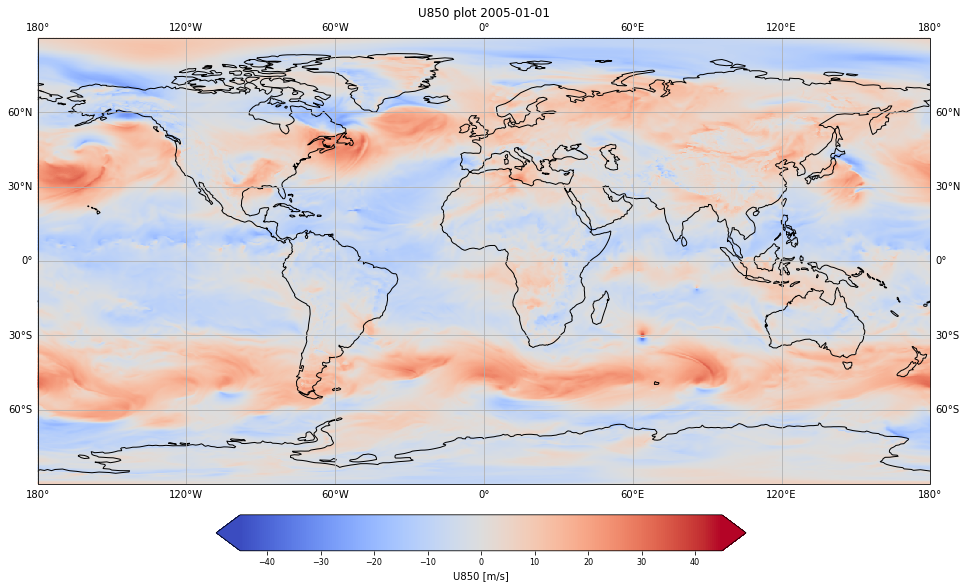

In [31]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot " + str(first_day.astype("M8[D]")))
ax.set_global()
mm = ax.pcolormesh(
    simulated_data['longitude'][()],
    simulated_data['latitude'][()],
    simulated_U850[np.where(simulated_time == first_day)[0][0], :, :],
    transform=ccrs.PlateCarree(),
    cmap=mpl.cm.coolwarm,
    vmin=-45,
    vmax=45)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850 [m/s]')
cbar.ax.tick_params(labelsize=8)
plt.savefig('./images/sample_CAM5.png', dpi=300)
plt.show()
plt.close()

The following script, which I suggest not to run, creates a gif from all of the maps over time, but just for the first 2 months (since it was too long to evaluate for all). I shall display here this aforementioned gif.
![SegmentLocal](images/wind_movie.gif "segment")

In [ ]:
for j, tt in progressbar.progressbar(
        enumerate(h5f['time'][()].astype("<M8[us]"))):
    if j < 500:
        fig = plt.figure(figsize=(23 / 2, 11 / 2))  # x,y(inches)

        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_title("U850 plot, time" + str(tt))
        ax.set_global()
        mm = ax.pcolormesh(simulated_data['longitude'][()],
                           simulated_data['latitude'][()],
                           simulated_U850['data'][j, :, :],
                           transform=ccrs.PlateCarree(),
                           cmap=mpl.cm.coolwarm,
                           vmin=-50,
                           vmax=50)

        ax.coastlines()
        ax.gridlines(draw_labels=True)

        #- add colorbar
        cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                                0.05])  #[left, bottom, width, height]
        cbar = fig.colorbar(mm,
                            cax=cbar_ax,
                            extend='both',
                            orientation='horizontal')
        cbar.set_label('U850')
        cbar.ax.tick_params(labelsize=8)
        plt.savefig('./images/U850_' + str(tt) + ".jpg")
        plt.close()
    else:
        break
        #     plt.show()
print("Creating GIF.")
images = [imageio.imread(filename) for filename in glob("./images/*.jpg")]
imageio.mimsave('./images/wind_movie.gif', images)

#### Temporal-aggregation

Givne the plot as above (see GIF), the next plot I present is a time-aggregation. That is, the average U850 wind for all coordinates in the given year (2005).

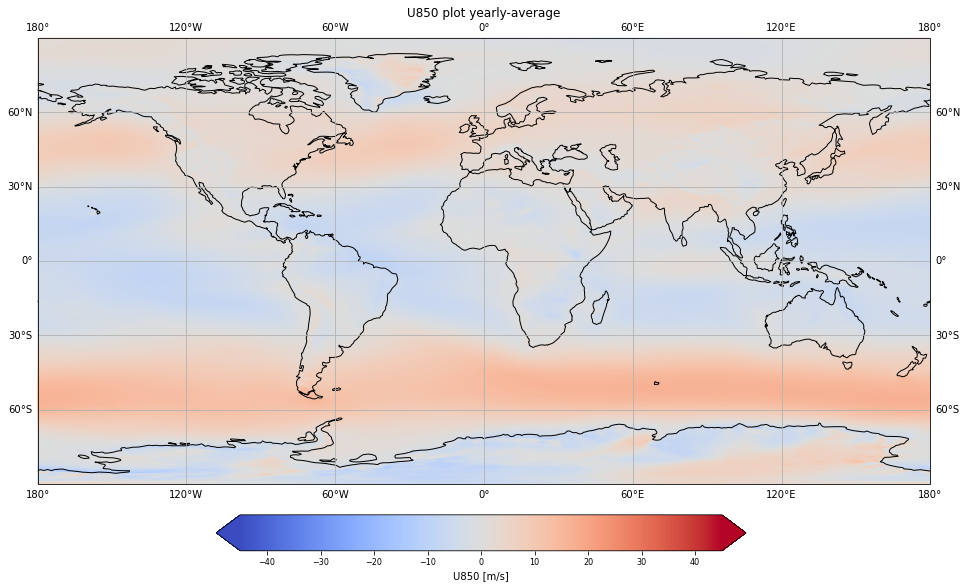

In [19]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot yearly-average")
ax.set_global()
mm = ax.pcolormesh(simulated_data['longitude'][()],
                   simulated_data['latitude'][()],
                   np.mean(simulated_U850, axis=0)[()],
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm,
                   vmin=-45,
                   vmax=45)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850 [m/s]')
cbar.ax.tick_params(labelsize=8)
plt.savefig("./images/average_CAM5.png", dpi=300)
plt.show()
plt.close()

#### Space-aggregation

In this Section, I present a **time-series** of the U850 time series for the whole world. More specifically, at each time step a spatial average is performed, and then it is plotted. The objective is to see if there are times of the year where the average wind on earth increases significantly.

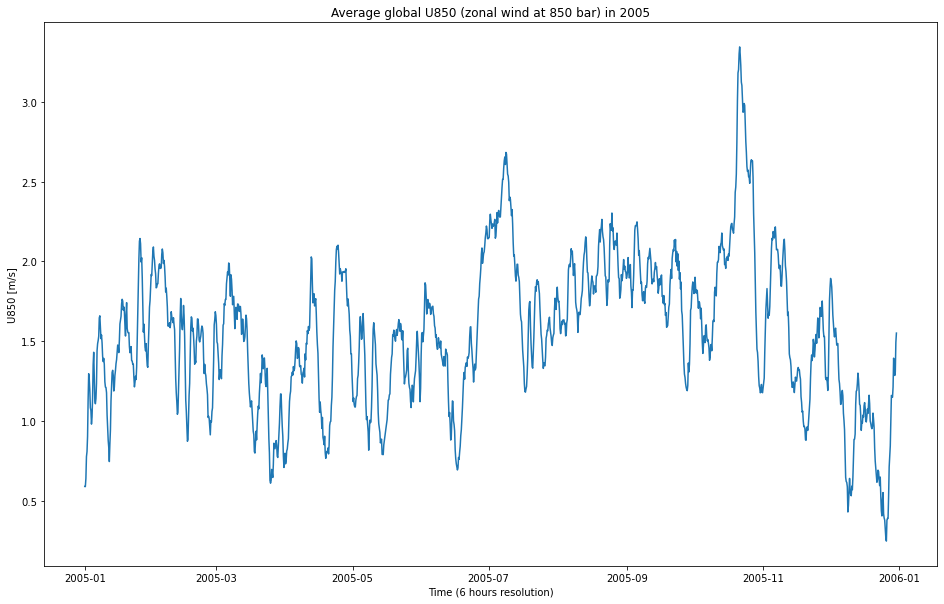

In [20]:
plt.figure(figsize=(16, 10))
plt.plot(simulated_time, np.mean(simulated_U850, axis=(1, 2)))
plt.title("Average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (6 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.savefig("./images/time_series_CAM5.pdf")
plt.show()

There are some exceptional spikes in the average. Let's see if they are connected to some well-known category-5 cylcons, of which 2005 experienced 5.

In [22]:
katrina_dates = np.arange("2005-08-23", "2005-08-31", dtype='datetime64[D]')
emily_dates = np.arange("2005-07-11", "2005-07-21", dtype='datetime64[D]')
rita_dates = np.arange("2005-09-18", "2005-09-26", dtype='datetime64[D]')
wilma_dates = np.arange("2005-10-15", "2005-10-27", dtype='datetime64[D]')

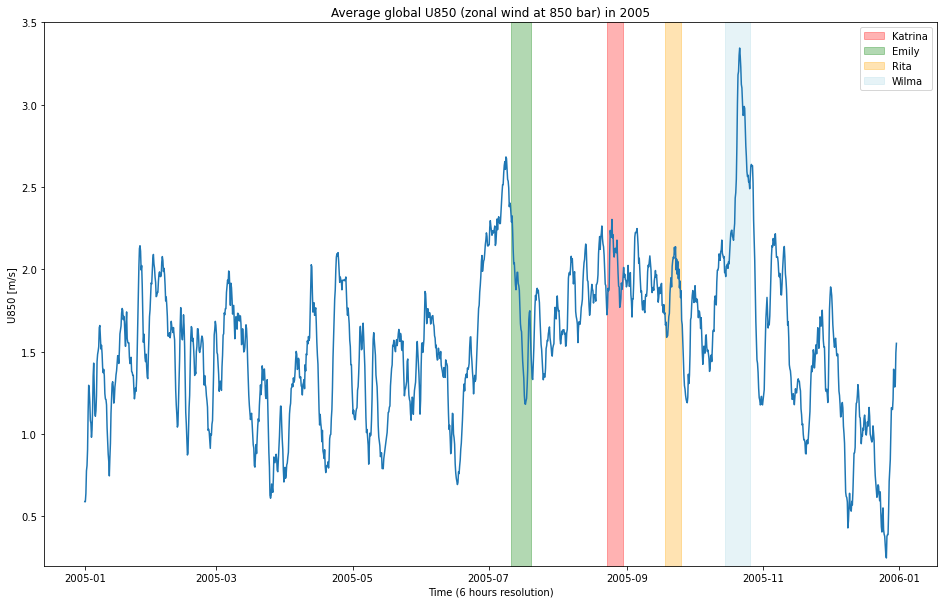

In [23]:
plt.figure(figsize=(16, 10))
plt.plot(simulated_time, np.mean(simulated_U850, axis=(1, 2)))
plt.fill_between(x=katrina_dates,
                 y1=3.5,
                 y2=0,
                 color='red',
                 alpha=0.3,
                 label='Katrina')
plt.fill_between(x=emily_dates,
                 y1=3.5,
                 y2=0,
                 color='green',
                 alpha=0.3,
                 label='Emily')
plt.fill_between(x=rita_dates,
                 y1=3.5,
                 y2=0,
                 color='orange',
                 alpha=0.3,
                 label='Rita')
plt.fill_between(x=wilma_dates,
                 y1=3.5,
                 y2=0,
                 color='lightblue',
                 alpha=0.3,
                 label='Wilma')
plt.ylim(0.2, 3.5)
plt.title("Average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (6 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.legend()
plt.show()

The CAM5 model does seem to have too a high correlation between the presence of category 5 cyclones and a higher wind speed. Indeed, for 3 of the 4 hurricanes analized, that is Katrina, Rita and Wilma, there are spikes in the wind speed: they may be caused by the cylone, or by other activities, so their presence should not be considered as causation.

### Real data PhysicalSociety

Here, the same analysis as for the real data is performed on the model generated one.

#### Single-date

In [26]:
# select one date
first_day = dataset.time.values[0]

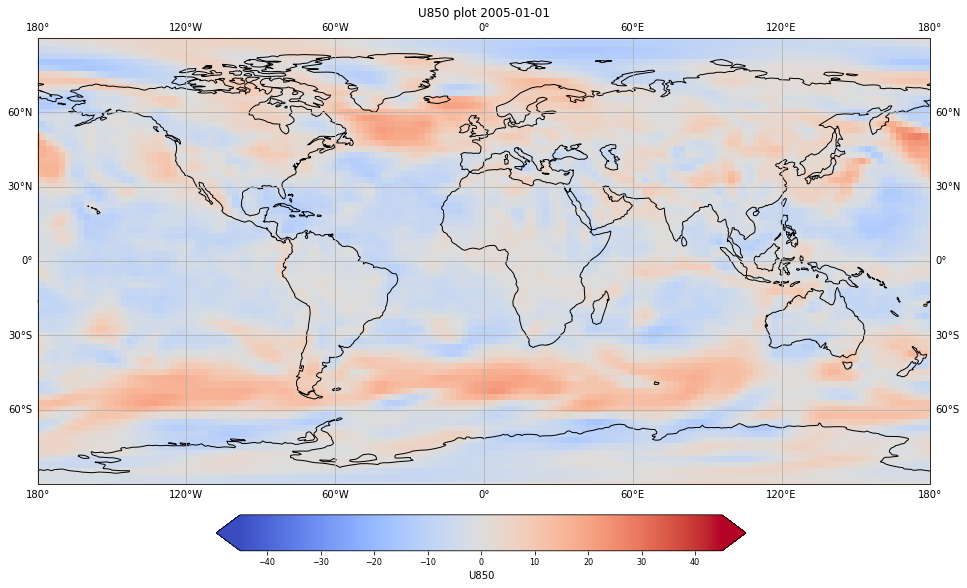

In [30]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot " + str(first_day.astype("M8[D]")))
ax.set_global()
mm = ax.pcolormesh(dataset.lon,
                   dataset.lat,
                   dataset.uwnd.values[np.where(
                       dataset.time.values == first_day)[0][0], :, :],
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm,
                   vmin=-45,
                   vmax=45)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850')
cbar.ax.tick_params(labelsize=8)
plt.savefig('./images/sample_PhysicalSociety.png', dpi=300)
plt.show()
plt.close()

#### Temporal-aggregation

Given the plot as above (see GIF), the next plot I present is a time-aggregation. That is, the average U850 wind for all coordinates in the given year (2005).

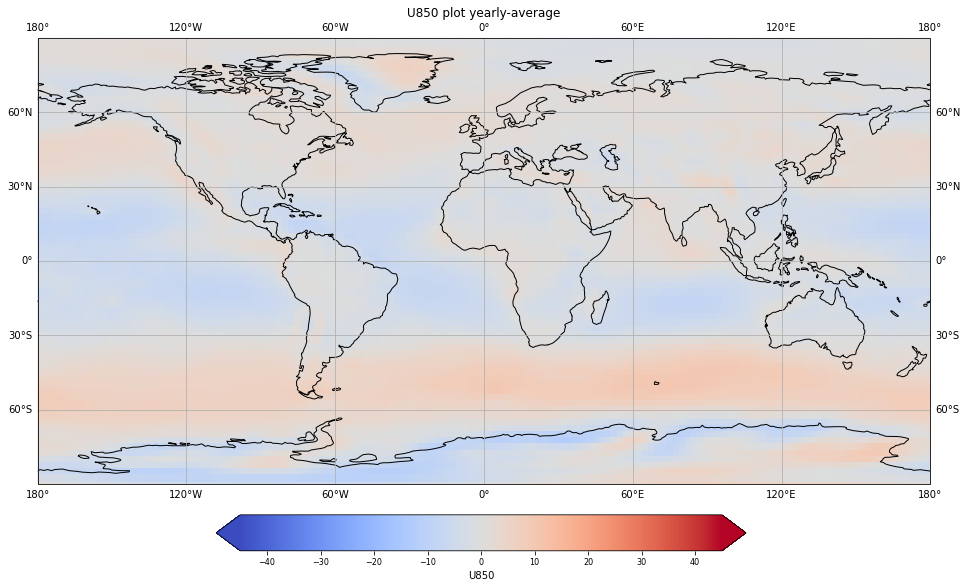

In [38]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot yearly-average")
ax.set_global()
mm = ax.pcolormesh(dataset.lon,
                   dataset.lat,
                   dataset.uwnd.mean(axis=0),
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm,
                   vmin=-45,
                   vmax=45)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850')
cbar.ax.tick_params(labelsize=8)
plt.savefig("./images/average_PhysicalSociety.png", dpi=300)
plt.show()
plt.close()

The first to notice is the much lower values of the wind when compared to the CAM5 model. This can be either due to the much lower resolution of the Physical Society satellite data, or to some other factors, e.g. the model overestimating.

#### Space-aggregation

In this Section, I present a **time-series** of the U850 time series for the whole world. More specifically, at each time step a spatial average is performed, and then it is plotted. The objective is to see if there are times of the year where the average wind on earth increases significantly.

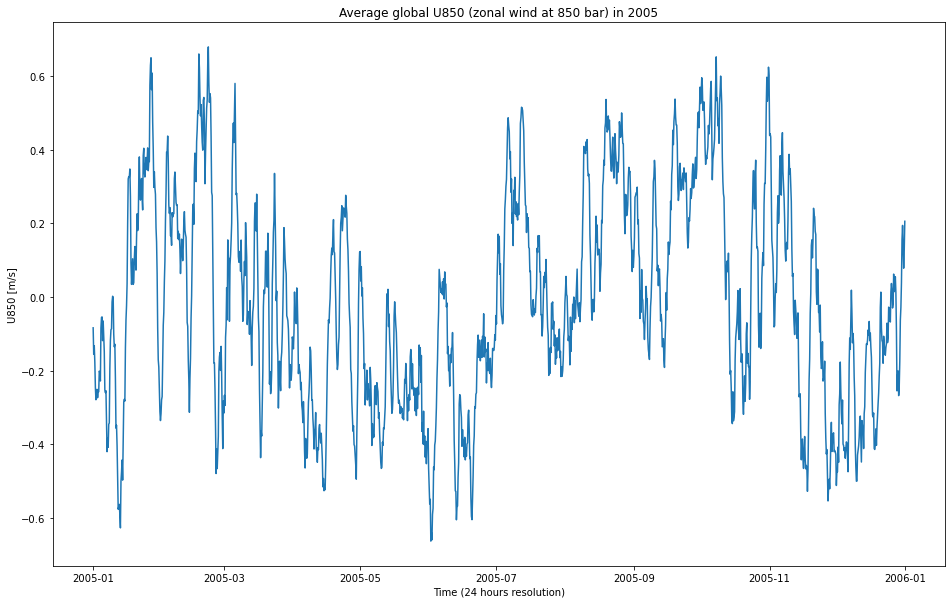

In [33]:
plt.figure(figsize=(16, 10))
plt.plot(dataset.time, dataset.uwnd.mean(axis=(1, 2)))
plt.title("Average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (24 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.savefig("./images/time_series_PhysicalSociety.pdf")
plt.show()

There are some exceptional spikes in the average. Let's see if they are connected to some well-known category-5 cylcons, of which 2005 experienced 5.

In [34]:
katrina_dates = np.arange("2005-08-23", "2005-08-31", dtype='datetime64[D]')
emily_dates = np.arange("2005-07-11", "2005-07-21", dtype='datetime64[D]')
rita_dates = np.arange("2005-09-18", "2005-09-26", dtype='datetime64[D]')
wilma_dates = np.arange("2005-10-15", "2005-10-27", dtype='datetime64[D]')

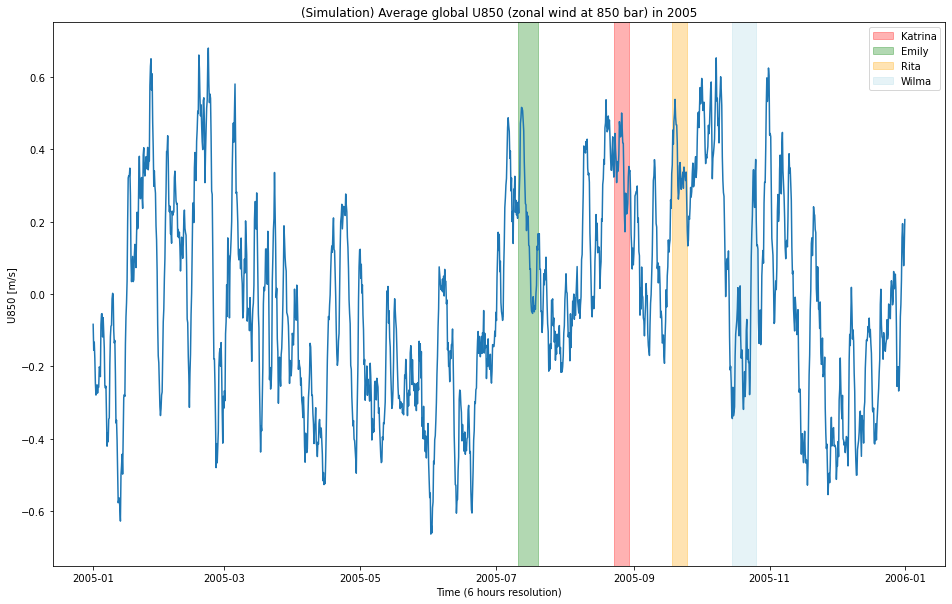

In [40]:
plt.figure(figsize=(16, 10))
plt.plot(dataset.time, dataset.uwnd.mean(axis=(1, 2)))
plt.fill_between(x=katrina_dates,
                 y1=1,
                 y2=-1,
                 color='red',
                 alpha=0.3,
                 label='Katrina')
plt.fill_between(x=emily_dates,
                 y1=1,
                 y2=-1,
                 color='green',
                 alpha=0.3,
                 label='Emily')
plt.fill_between(x=rita_dates,
                 y1=1,
                 y2=-1,
                 color='orange',
                 alpha=0.3,
                 label='Rita')
plt.fill_between(x=wilma_dates,
                 y1=1,
                 y2=-1,
                 color='lightblue',
                 alpha=0.3,
                 label='Wilma')
plt.ylim(-0.75, 0.75)
plt.title("(Simulation) Average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (6 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.legend()
plt.show()

Some patterns may be discerned, but there appears to be not to be a much more interesting result when compared to the CAM5 model.

### Real data Copernicus

A similar analysis is performed on the other dataset of real-recorded wind.

#### Single-date

In [8]:
# select one date
first_day = dataset2.time.values[0]

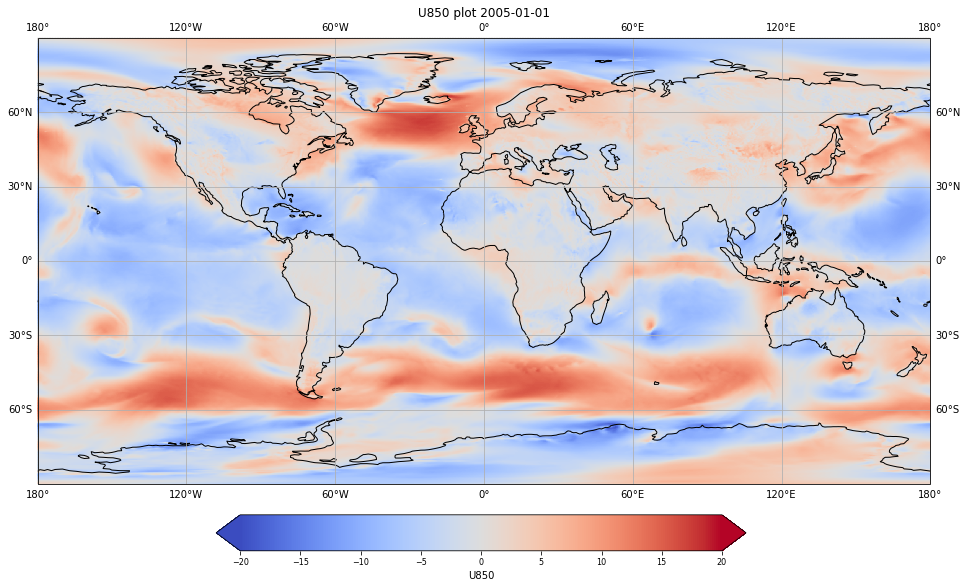

In [17]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot " + str(first_day.astype("M8[D]")))
ax.set_global()
mm = ax.pcolormesh(dataset2.longitude,
                   dataset2.latitude,
                   dataset2.u10.values[np.where(
                       dataset2.time.values == first_day)[0][0], :, :],
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm,
                   vmin=-20,
                   vmax=20)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850')
cbar.ax.tick_params(labelsize=8)
plt.savefig('./images/sample_Copernicus.png', dpi=300)
plt.show()
plt.close()

#### Temporal-aggregation

Given the plot as above (see GIF), the next plot I present is a time-aggregation. That is, the average U850 wind for all coordinates in the given year (2005).

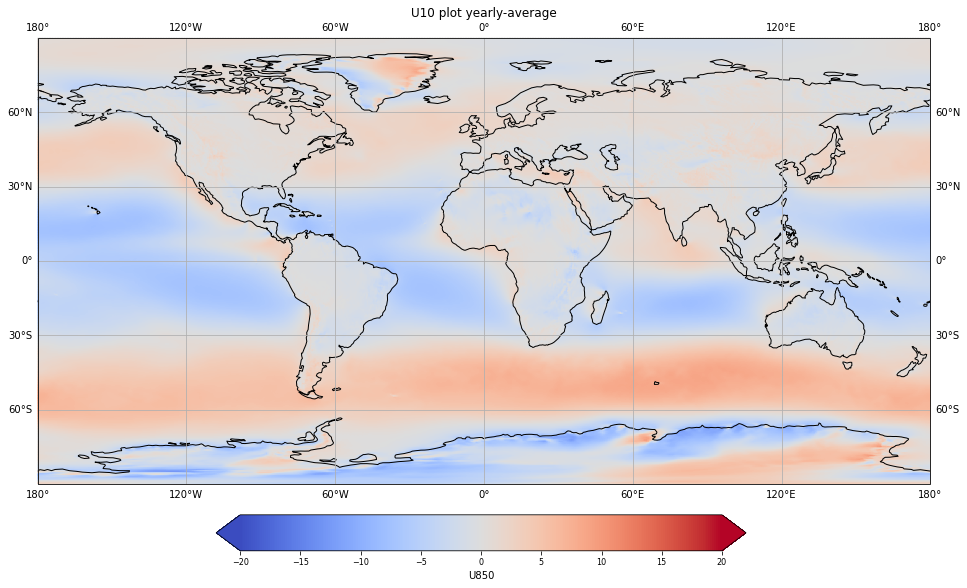

In [16]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U10 plot yearly-average")
ax.set_global()
mm = ax.pcolormesh(dataset2.longitude,
                   dataset2.latitude,
                   dataset2.u10.mean(axis=0),
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm,
                   vmin=-20,
                   vmax=20)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850')
cbar.ax.tick_params(labelsize=8)
plt.savefig("./images/average_Copernicus.png", dpi=300)
plt.show()
plt.close()

The first to notice is the much lower values of the wind when compared to the CAM5 model. This can be either due to the much lower resolution of the Physical Society satellite data, or to some other factors, e.g. the model overestimating.

#### Space-aggregation

In this Section, I present a **time-series** of the U850 time series for the whole world. More specifically, at each time step a spatial average is performed, and then it is plotted. The objective is to see if there are times of the year where the average wind on earth increases significantly.

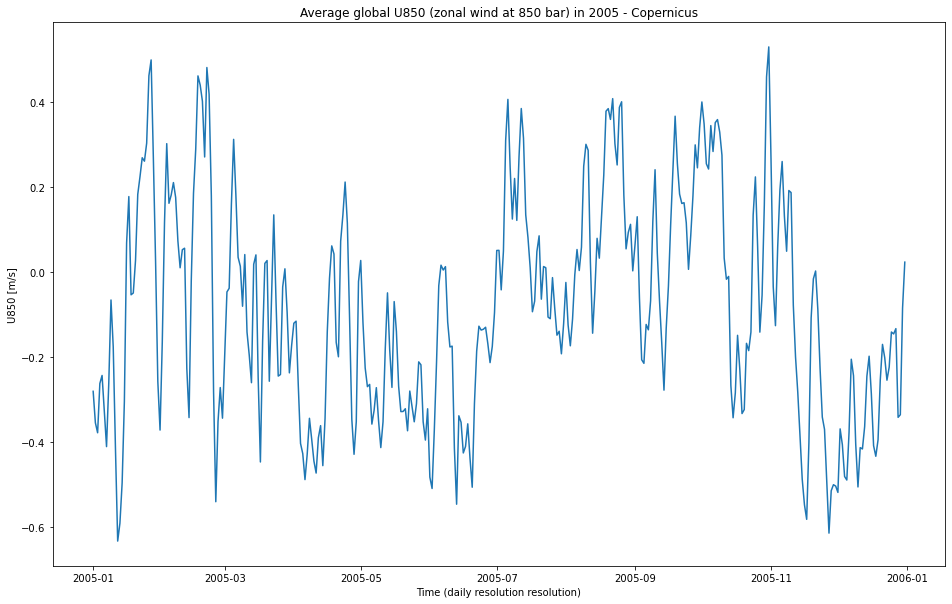

In [19]:
plt.figure(figsize=(16, 10))
plt.plot(dataset2.time, dataset2.u10.mean(axis=(1, 2)))
plt.title("Average global U850 (zonal wind at 850 bar) in 2005 - Copernicus")
plt.xlabel("Time (daily resolution resolution)")
plt.ylabel("U850 [m/s]")
plt.savefig("./images/time_series_Copernicus.pdf")
plt.show()

There are some exceptional spikes in the average. Let's see if they are connected to some well-known category-5 cylcons, of which 2005 experienced 5.

In [20]:
katrina_dates = np.arange("2005-08-23", "2005-08-31", dtype='datetime64[D]')
emily_dates = np.arange("2005-07-11", "2005-07-21", dtype='datetime64[D]')
rita_dates = np.arange("2005-09-18", "2005-09-26", dtype='datetime64[D]')
wilma_dates = np.arange("2005-10-15", "2005-10-27", dtype='datetime64[D]')

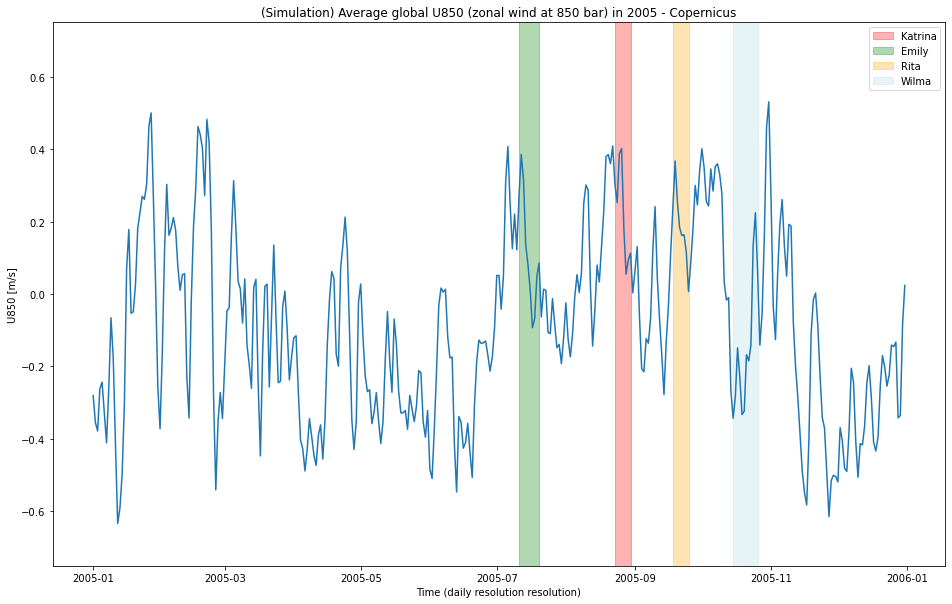

In [21]:
plt.figure(figsize=(16, 10))
plt.plot(dataset2.time, dataset2.u10.mean(axis=(1, 2)))
plt.fill_between(x=katrina_dates,
                 y1=1,
                 y2=-1,
                 color='red',
                 alpha=0.3,
                 label='Katrina')
plt.fill_between(x=emily_dates,
                 y1=1,
                 y2=-1,
                 color='green',
                 alpha=0.3,
                 label='Emily')
plt.fill_between(x=rita_dates,
                 y1=1,
                 y2=-1,
                 color='orange',
                 alpha=0.3,
                 label='Rita')
plt.fill_between(x=wilma_dates,
                 y1=1,
                 y2=-1,
                 color='lightblue',
                 alpha=0.3,
                 label='Wilma')
plt.ylim(-0.75, 0.75)
plt.title(
    "(Simulation) Average global U850 (zonal wind at 850 bar) in 2005 - Copernicus"
)
plt.xlabel("Time (daily resolution resolution)")
plt.ylabel("U850 [m/s]")
plt.legend()
plt.show()

For this data, there are some spikes in correspondance to all major hurricane events. Nonetheless, there is a large number of fluctioations. ,and this a real meaning or correlation would be difficult to infer.

## Multi-data visualizations

Given the separate results above confrontations shall be performed. In particular, we are interested in seeing how over the year the two time series, i.e. the real data and the simulation, differ. A second confrontation shall on the plot of the yearly-average, to see in which positions the model tends to underperform: for this case scenario, the use of *re-gridding* is necessary.

Most of the multi-data visualizations shall be performed between the simulated (CAM5 model) data and the PhysicalSociety recordings. The Copernicus U10 data shall be used only for a time series confrontations.

### Temporal-Aggregation

#### CAM5 vs PhysicalSociety

We shall evaluate the difference between the yearly averages for 2005 between the real data and the model-generated one.

In order to allow for a fair comparison, I decide to rescale the data on their means.

In [10]:
# Create the Xarray Datasets
# which allow to re-grid
simulated_mean = xr.Dataset({
    'images': (('lat', 'lon'), np.mean(simulated_U850, axis=0)[()]),
    'images_scaled':
    (('lat', 'lon'), (np.mean(simulated_U850, axis=0)[()] -
                      np.mean(simulated_U850, axis=(0, 1, 2))[()])),
    "lat":
    simulated_data['latitude'][()],
    "lon":
    simulated_data['longitude'][()]
})

real_mean = xr.Dataset({
    'images': (('lat', 'lon'), np.mean(dataset.uwnd.values, axis=0)[()]),
    'images_scaled':
    (('lat', 'lon'), (np.mean(dataset.uwnd.values, axis=0)[()] -
                      np.mean(dataset.uwnd.values, axis=(0, 1, 2))[()])),
    "lat":
    dataset.lat,
    "lon":
    dataset.lon
})

The regridding shall be performed as an *oversampling* of the satellite data.

In [27]:
dataset_i = real_mean.interp(lat=simulated_mean.lat,
                             lon=simulated_mean.lon,
                             method='linear',
                             kwargs={"fill_value": "extrapolate"})

In [28]:
diff_U850 = dataset_i - simulated_mean

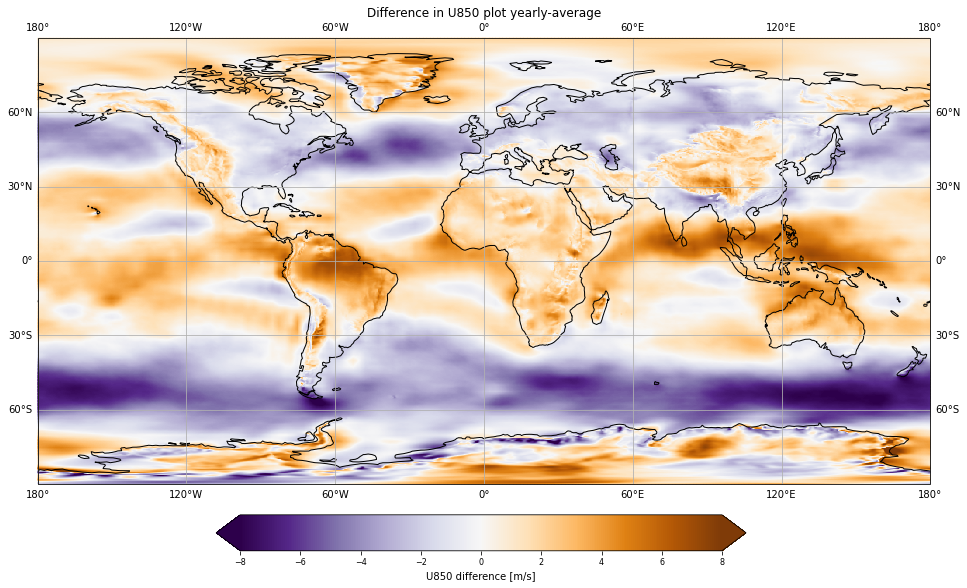

In [30]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("Difference in U850 plot yearly-average")
ax.set_global()
mm = ax.pcolormesh(diff_U850.lon,
                   diff_U850.lat,
                   diff_U850.images_scaled,
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.PuOr_r,
                   vmin=-8,
                   vmax=8)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850 difference [m/s]')
cbar.ax.tick_params(labelsize=8)
plt.savefig("./images/average_diff_CAM5vPhysicalSociety.png", dpi=300)
plt.show()
plt.close()

The plot gives some interesting results: the CAM5 model apparently underestimates some areas of the globe (in orange), for example the area around Brasil or the Indian ocean, while it underestimates the very strong southern hemisphere current. 

#### CAM5 vs Copernicus

A similar analysis as above is carried out for the Copernicus data. Indeed, since the spatial dimensions of the simulation and the satellite data are quite similar to one another, we should expect some higher-definition results (considering that the above PhysicalSociety data was aumented for most spatial points).

In [24]:
# Create the Xarray Datasets
# which allow to re-grid
simulated_mean = xr.Dataset({
    'images': (('latitude', 'longitude'), np.mean(simulated_U850, axis=0)[()]),
    'images_scaled':
    (('latitude', 'longitude'), (np.mean(simulated_U850, axis=0)[()] -
                      np.mean(simulated_U850, axis=(0, 1, 2))[()])),
    "latitude":
    simulated_data['latitude'][()],
    "longitude":
    simulated_data['longitude'][()]
})

real_mean = xr.Dataset({
    'images': (('latitude', 'longitude'), np.mean(dataset2.u10.values, axis=0)[()]),
    'images_scaled':
    (('latitude', 'longitude'), (np.mean(dataset2.u10.values, axis=0)[()] -
                      np.mean(dataset2.u10.values, axis=(0, 1, 2))[()])),
    "latitude":
    dataset2.latitude,
    "longitude":
    dataset2.longitude
})

In [25]:
dataset_i = real_mean.interp(latitude=simulated_mean.latitude,
                             longitude=simulated_mean.longitude,
                             method='linear',
                             kwargs={"fill_value": "extrapolate"})

In [26]:
diff_U850 = dataset_i - simulated_mean

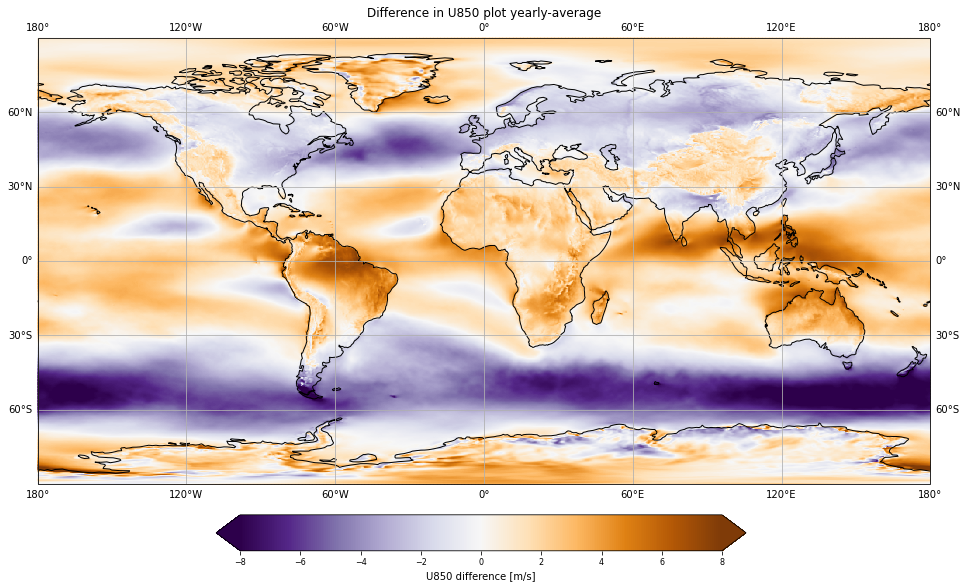

In [28]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("Difference in U850 plot yearly-average")
ax.set_global()
mm = ax.pcolormesh(diff_U850.longitude,
                   diff_U850.latitude,
                   diff_U850.images_scaled,
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.PuOr_r,
                   vmin=-8,
                   vmax=8)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850 difference [m/s]')
cbar.ax.tick_params(labelsize=8)
plt.savefig("./images/average_diff_CAM5vCopernicus.png", dpi=300)
plt.show()
plt.close()

### Space Aggregation

The other confrontation is here shown: first a plot with both time series shall be presented, in order to distinguish similarities either in shape or form; and then a plot of the differences is given.

Notice that the data must be rescaled to their mean to allow for a confrontation (the evaluation of **anomalies** should be performed, but cannot due to lack of data).

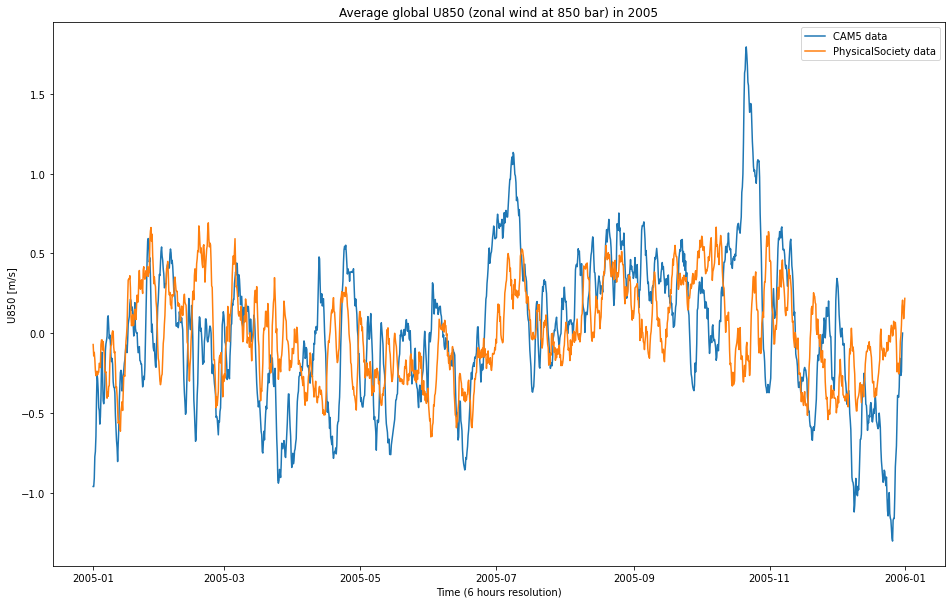

In [39]:
plt.figure(figsize=(16, 10))
plt.plot(simulated_time,
         np.mean(simulated_U850, axis=(1, 2)) -
         np.mean(simulated_U850, axis=(0, 1, 2)),
         label='CAM5 data')
plt.plot(dataset.time,
         dataset.uwnd.mean(axis=(1, 2)) - dataset.uwnd.mean(axis=(0, 1, 2)),
         label='PhysicalSociety data')
plt.title("Average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (6 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.legend()
plt.savefig("./images/time_series_together_CAM5vPhysicalSociety.pdf")
plt.show()

The plots are not far from each other. Most importantly, the first peak in July is somewhat correctly guessed by the simulation. The other important fact is that the Physical Society data tends to have less strong fluctuations: this may be due to its much lower resolution.

Let's see in the next graph the actual difference between the two time series, and then try to see if this difference is stationary or not.

In [41]:
time_diff = (dataset.uwnd.mean(axis=(1, 2))[:-4] -
             dataset.uwnd.mean(axis=(0, 1, 2)) -
             (np.mean(simulated_U850, axis=(1, 2)) -
              np.mean(simulated_U850, axis=(0, 1, 2))))

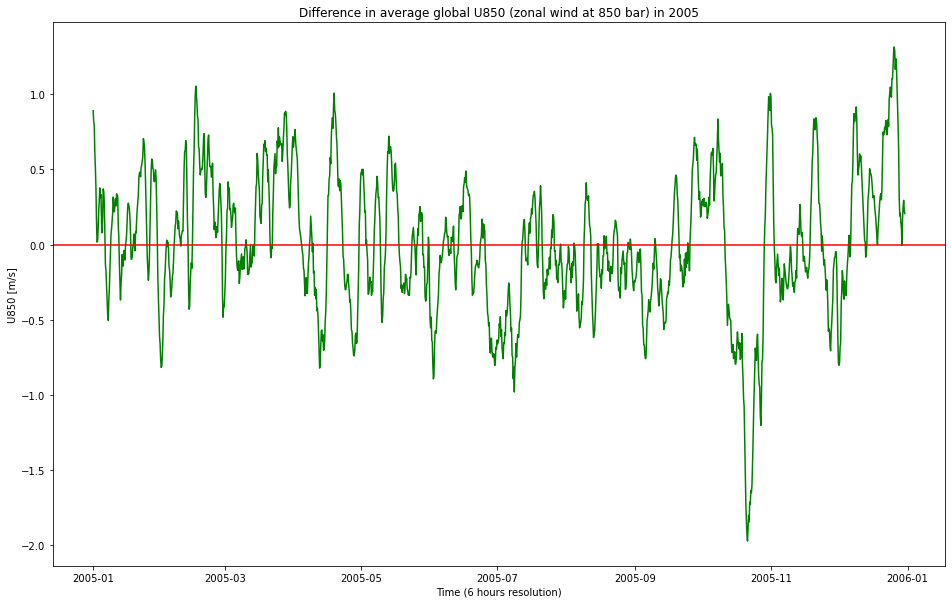

In [42]:
plt.figure(figsize=(16, 10))
# plt.plot(fake_dates[:-1], np.mean(real_data_reshaped, axis = (1,2)), label = 'real data')
plt.plot(dataset.time[:-4], time_diff, color='green')
plt.title("Difference in average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (6 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.axhline(0, color='red')
plt.savefig("./images/time_series_diff_CAM5vPhysicalSociety.pdf")
plt.show()

The plot difference highlight a similar story to the previous one. The noticible value is in the corrispondance with the end-of-october peak in the simulated data, which is not present in the real one.

The Augmented Dickey-Fuller test is performed: this test tries to see if the time series is stationary or not. That is, if its mean is 0 and its variance is constant in time.

In [46]:
print("Augmneted Dickey-Fuller test.\np-value: %.6f" %
      (adfuller(time_diff)[1]))

Augmneted Dickey-Fuller test.
p-value: 0.000002


Since the test shows statistical significance, it means that the null hypothesis (non-stationarity) can be rejected: the time series is most likely stationary.
This means that no systematic errors are present in the simulated model, and that differences are most likely statistical.

### Tree-way temporal aggregation

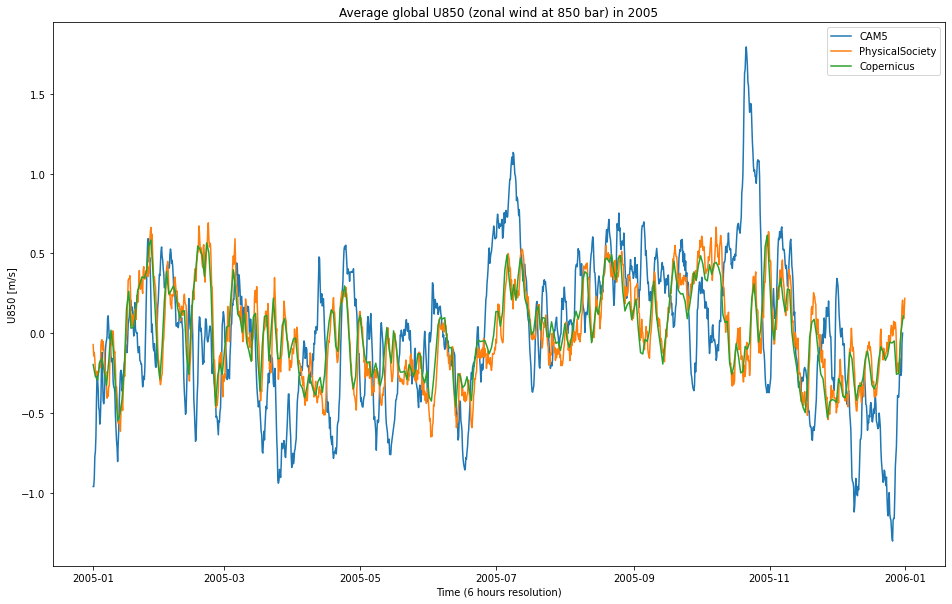

In [22]:
plt.figure(figsize=(16, 10))
plt.plot(simulated_time,
         np.mean(simulated_U850, axis=(1, 2)) -
         np.mean(simulated_U850, axis=(0, 1, 2)),
         label='CAM5')
plt.plot(dataset.time,
         dataset.uwnd.mean(axis=(1, 2)) - dataset.uwnd.mean(axis=(0, 1, 2)),
         label='PhysicalSociety')
plt.plot(dataset2.time,
         dataset2.u10.mean(axis=(1, 2)) - dataset2.u10.mean(axis=(0, 1, 2)),
         label='Copernicus')
plt.title("Average global U850 (zonal wind at 850 bar) in 2005")
plt.xlabel("Time (6 hours resolution)")
plt.ylabel("U850 [m/s]")
plt.legend()
plt.savefig(
    "./images/time_series_together_CAM5vPhysicalSocietyvCopernicus.pdf")
plt.show()

A very nice result is that the Copernicus and PhysicalSociety data, when rescaled on their mean, have a very good degree of accordance. The advantage of using the latter might be that of higher resolution.

### Temporale-Aggregation Real

Let us see if there are some positional differences between the data Copernicus and the PhysicalSociety data. Indeed, we would expect none to be present, but the much lower resolution of the PhysicalSociety recordings might play some role in this.

In [7]:
print("PhysicalSociety Resolution:", dataset.uwnd.shape[1:])
print("Copernicus Resolution:", dataset2.u10.shape[1:])

PhysicalSociety Resolution: (73, 144)
Copernicus Resolution: (721, 1440)


The latter data has almost 10 times the resolution.

In [13]:
# Create the Xarray Datasets
# which allow to re-grid
real_mean_2 = xr.Dataset({
    'images': (('latitude', 'longitude'), np.mean(dataset2.u10.values,
                                                  axis=0)[()]),
    'images_scaled': (('latitude', 'longitude'),
                      (np.mean(dataset2.u10.values, axis=0)[()] -
                       np.mean(dataset2.u10.values, axis=(0, 1, 2))[()])),
    "latitude":
    dataset2['latitude'][()],
    "longitude":
    dataset2['longitude'][()]
})

real_mean = xr.Dataset({
    'images': (('lat', 'lon'), np.mean(dataset.uwnd.values, axis=0)[()]),
    'images_scaled':
    (('lat', 'lon'), (np.mean(dataset.uwnd.values, axis=0)[()] -
                      np.mean(dataset.uwnd.values, axis=(0, 1, 2))[()])),
    "lat":
    dataset.lat,
    "lon":
    dataset.lon
})

The regridding shall be performed as an *oversampling* of the satellite data.

In [15]:
# interpolate the lower resolution images
dataset_i = real_mean.interp(lat=real_mean_2.latitude,
                             lon=real_mean_2.longitude,
                             method='linear',
                             kwargs={"fill_value": "extrapolate"})

dataset_i = dataset_i.drop(['lat', 'lon'])

dataset_i = dataset_i.drop("images")
real_mean_2 = real_mean_2.drop("images")

In [23]:
diff_U850 = dataset_i - real_mean_2

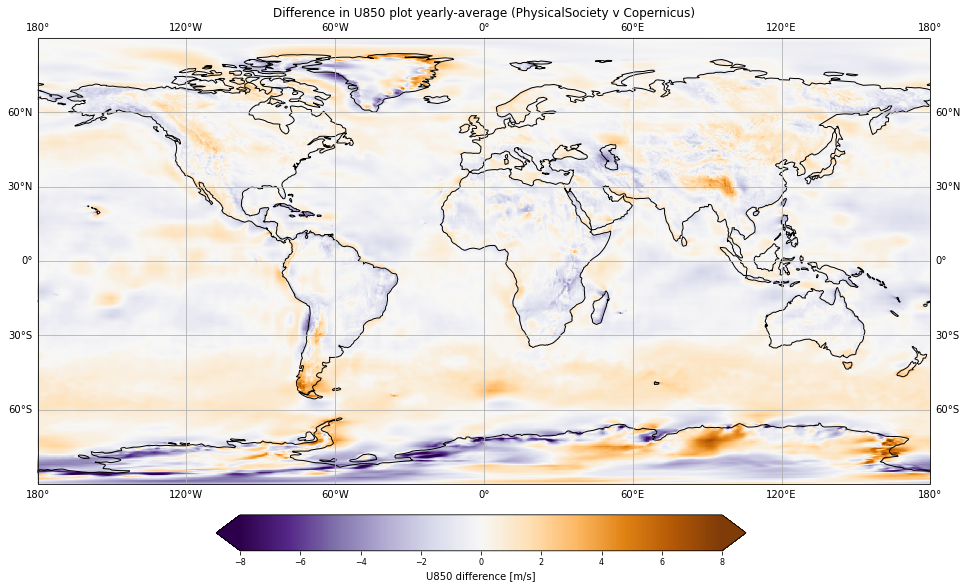

In [26]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(
    "Difference in U850 plot yearly-average (PhysicalSociety v Copernicus)")
ax.set_global()
mm = ax.pcolormesh(diff_U850.longitude,
                   diff_U850.latitude,
                   diff_U850.images_scaled,
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.PuOr_r,
                   vmin=-8,
                   vmax=8)

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850 difference [m/s]')
cbar.ax.tick_params(labelsize=8)
plt.savefig("./images/average_diff_CopernicusvPhysicalSociety.png", dpi=300)
plt.show()
plt.close()

While for the majorituy of the globe the result is as expected, that is very small differences, there are some parts where the PhysicalSociety data tends to give either higher or lower results than the Copernicus. This could probably be mostly attributed to the use of interpolation, but a more specific reason would be much more difficult to discern.